# CEE 4800 Final Project Code (Appendix B)

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## B.1 Loading in Data

In [2]:
data = pd.read_csv('/work/Precip_data.csv')

df = pd.DataFrame(data)

df = df[['HPCP', 'DATE']]

# Convert 'DATA' column to datetime and format it
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d %H:%M')

df.head()


,HPCP,DATE
0,0.00,2000-01-01 01:00:00
1,0.00,2000-01-02 10:00:00
2,0.00,2000-01-02 11:00:00
3,0.00,2000-01-02 18:00:00
4,0.02,2000-01-02 19:00:00


## B.2 Unit Hydrograph

### B.2.1 Watershed Characteristics 

In [3]:
#Watershed Characteristics
L = 1.8 # Length (MI)
S = 0.0024 #Slope (ft/ft)
A_w = 0.9 #Watershed Area (MI^2)

tc = 21.3*L*(A_w**(-0.1))*(S**(-0.2)) #Time of Concentration

dD = 0.133 * tc #Timestep for UH

tp = 0.5*dD + 0.6*tc #Time to peak

tr = 1.6*tp # Time of Recession

qp = (484*A_w)/tp # Peak Flow

s_p = qp/tp # Slope to Peak

s_r = qp/tr # Slope to Recession

### B.2.2 Unit Vector Calculation

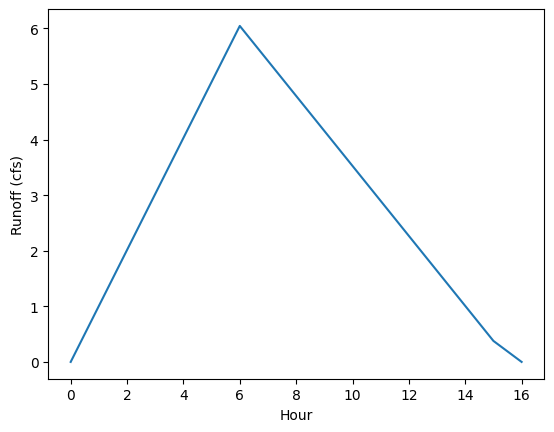

In [4]:
U = [0.00001]
exceeded_qp = False  # Flag to indicate if U[-1] has exceeded qp

while U[-1] > 0:
    if not exceeded_qp and U[-1] < qp:
        U.append(U[-1] + s_p * dD)
    else:
        exceeded_qp = True
        u_t = U[-1] - s_r * dD  # Set flag to True, so 'if' is bypassed in future iterations
        u_t = np.where(u_t >= 0, u_t, 0)
        U.append(u_t)

plt.plot(U)
plt.xlabel('Hour')
plt.ylabel('Runoff (cfs)')
plt.show()

### B.2.3 Unit Hydrograph Caluclation

In [5]:
# 100yr storm
p_24_storm = df[df['HPCP'].idxmax()-12:df['HPCP'].idxmax()+12]

# 10 year analysis
p_24_10yr = df[(df['DATE'].dt.year >= 2003) & (df['DATE'].dt.year <= 2013)]

#Dataset of study: (PUT IN DESIRED DATASET INTO p_24 VARIABLE)
p_24 = p_24_10yr

# Curve Number parameters
CN = 95
S_cn = (1000 / CN) - 10
I_a = S_cn * 0.2

# Double Precip for robustness -- Optional
#p_24['HPCP'] = p_24['HPCP']*2

# Calculate effective rainfall depth for each hour
p_24_depth = np.where(p_24['HPCP'] > I_a, ((p_24['HPCP'] - 0.2 * S_cn) ** 2) / (p_24['HPCP'] + 0.8 * S_cn), 0)

# Convert to array if not already
cn_runoff = np.array(p_24_depth)

# Unit hydrograph in cfs/inch, assumed to be already defined as U
unit_hydrograph = np.array(U)

# Calculate runoff using convolution
runoff = np.convolve(cn_runoff, unit_hydrograph, mode='full')

# Limit runoff to the original length of rainfall + unit hydrograph duration
runoff = runoff[:len(cn_runoff) + len(unit_hydrograph) - 1]

# Create a DataFrame to display the runoff over time
df_runoff = pd.DataFrame({
    'Hour': np.arange(len(runoff)),
    'Runoff (cfs)': runoff
})

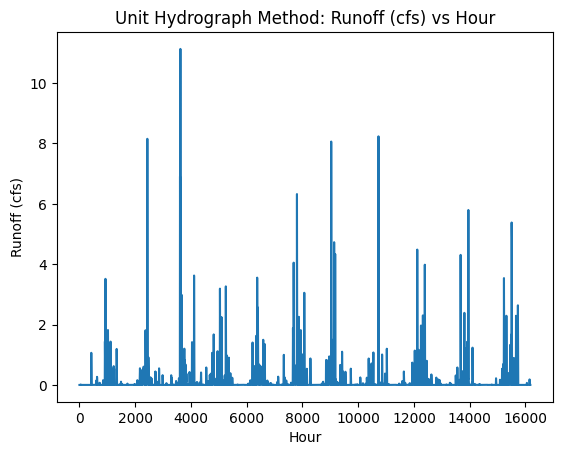

In [6]:
plt.plot(df_runoff['Runoff (cfs)'])
plt.xlabel('Hour')
plt.ylabel('Runoff (cfs)')
plt.title ('Unit Hydrograph Method: Runoff (cfs) vs Hour')
plt.show()

## B.3 Modeling

### B.3.1 Smart Model

In [7]:
Q = df_runoff['Runoff (cfs)'].values  # Ensure Q is a NumPy array

WL = [6.6]  # Water Level, starts at 6.6 ft
ABD = [0]  # Available Basin Depth, starts at 0 ft
TB = 0.05  # Buffer
DD = [0]  # Drainage Depth

A = 5.2 * 43560  # Area of Retention Basin in square feet

RD = Q / A  # Runoff Depth

secs = 3600

Q_pump_max = 5 *secs  # Maximum pump capacity in cfh
Q_pump_min = 0.01 *secs   # Minimum pump capacity in cfh

QD_pump_max = Q_pump_max / A  # Max drainage depth per second
QD_pump_min = Q_pump_min / A  # Min drainage depth per second

QD_pump = [0]

QD_weir = [0]

# Helper function for weir
def weir(abd):
    C = 3.3 # ft
    H = abs(abd) if abd < 0 else 0
    q = C*L*(H**1.5)
    return q

# Iterate over Q to calculate DD and ABD dynamically
for i in range(len(Q)-1):
    # Step 1: Calculate weir outflow depth
    weir_outflow = weir(ABD[i])*secs / A  

    # Look at runoff one hour into the future
    runoff = RD[i+1]*secs

    # Step 2: Compute the remaining drainage depth after weir outflow
    dd = runoff * (1 + TB) - weir_outflow

    # Step 3: Pumping logic based on the remaining depth
    if ABD[i] - dd > 0:
        pump_req = 0
    else:
        pump_req = dd - (ABD[i] if ABD[i] < 0 else 0)  # Adjust for ABD if negative
    
    if pump_req < QD_pump_min:
        pump_outflow = 0
    elif pump_req > QD_pump_max:
        pump_outflow = QD_pump_max
    else:
        pump_outflow = pump_req

    # Step 4: Update ABD considering RD, pump outflow, and weir outflow
    abd = ABD[i] - runoff + pump_outflow + weir_outflow

    # Append to the lists
    DD.append(dd)
    ABD.append(abd)
    QD_pump.append(pump_outflow)
    QD_weir.append(weir_outflow)

# Convert results back to NumPy arrays if needed
DD = np.array(DD)
ABD = np.array(ABD)
QD_pump = np.array(QD_pump)
QD_weir = np.array(QD_weir)



### B.3.2 Null Model

In [8]:
WL_null = [6.6]  # Water Level, starts at 6.6 ft
ABD_null = [0]  # Available Basin Depth, starts at 0 ft
TB_null = 0.05  # Buffer
DD_null = [0]  # Drainage Depth

QD_weir_null = [0]

# Iterate over Q to calculate DD and ABD dynamically
# Iterate over Q to calculate DD and ABD dynamically
for i in range(len(Q)):
    # Step 1: Calculate weir outflow depth
    weir_outflow = weir(ABD_null[i])*secs / A  

    runoff = RD[i]*secs #runoff in cf/hr

    # Step 4: Update ABD considering RD, pump outflow, and weir outflow
    abd_null = ABD_null[i] - runoff + weir_outflow

    # Append to the lists
    ABD_null.append(abd_null)
    QD_weir_null.append(weir_outflow)

# Convert results back to NumPy arrays if needed
ABD_null = np.array(ABD_null)
QD_weir_null = np.array(QD_weir_null)

### B.3.3 Model Plotting Code

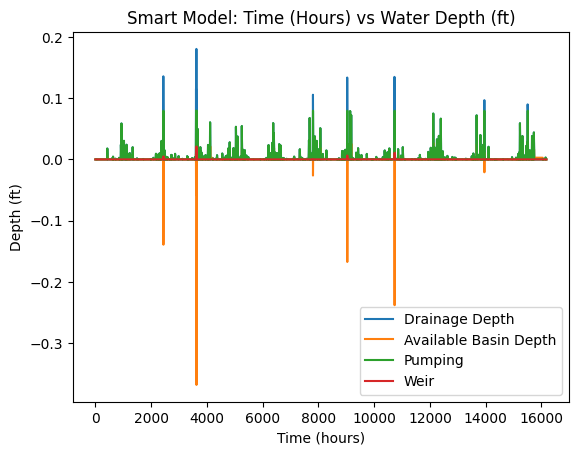

In [9]:
# SMART MODEL

plt.plot(DD, label='Drainage Depth')
plt.plot(ABD, label='Available Basin Depth')
plt.plot(QD_pump, label='Pumping')
plt.plot(QD_weir, label='Weir')
plt.xlabel('Time (hours)')
plt.ylabel('Depth (ft)')
plt.title ('Smart Model: Time (Hours) vs Water Depth (ft)')
plt.legend()
plt.show()

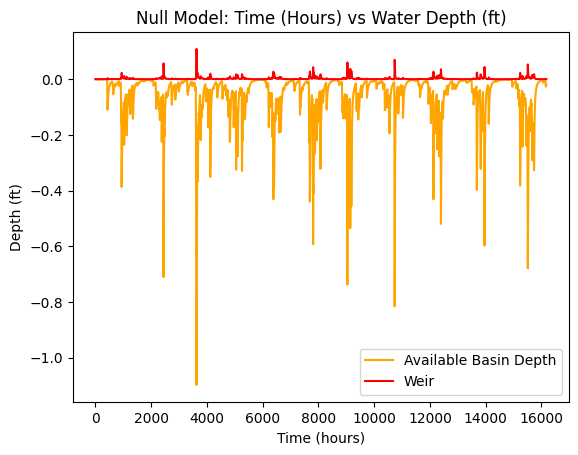

In [10]:
# NULL MODEL

plt.plot(ABD_null, color = 'orange',label='Available Basin Depth')
plt.plot(QD_weir_null, color = 'red', label='Weir')
plt.xlabel('Time (hours)')
plt.ylabel('Depth (ft)')
plt.title ('Null Model: Time (Hours) vs Water Depth (ft)')
plt.legend()
plt.show()

## B.4 Flooding Analysis

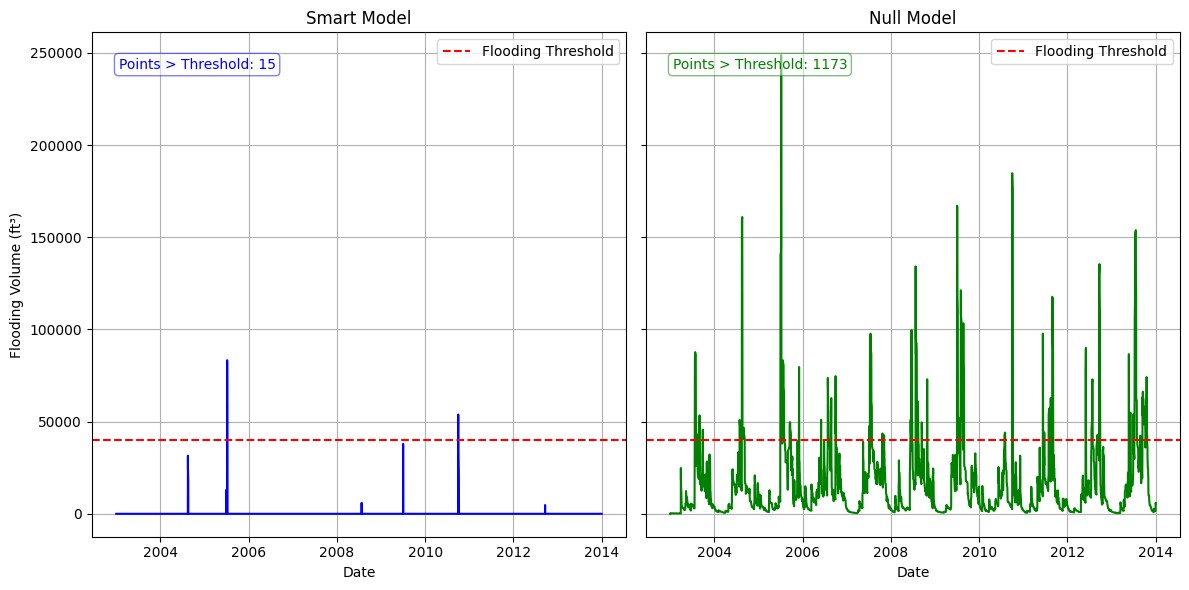

In [11]:
# Calculate flooding volumes for both models
flooding_smart = np.where(ABD < 0, abs(ABD * A), 0)
flooding_null = np.where(ABD_null < 0, abs(ABD_null * A), 0)

dates = p_24_10yr['DATE']

threshold = 40000
# Count points exceeding the threshold
smart_above_threshold = np.sum(flooding_smart > threshold)
null_above_threshold = np.sum(flooding_null > threshold)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Smart Model subplot
axes[0].plot(dates, flooding_smart[:-1*len(U)+1], color='blue')
axes[0].set_title("Smart Model")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Flooding Volume (ft³)")
axes[0].axhline(y=threshold, color='red', linestyle='--', label='Flooding Threshold')
axes[0].text(
    0.05, 0.95, f"Points > Threshold: {smart_above_threshold}",
    transform=axes[0].transAxes, fontsize=10, color='blue',
    verticalalignment='top', bbox=dict(boxstyle="round", fc="white", ec="blue", alpha=0.5)
)
axes[0].legend()
axes[0].grid(True)

# Null Model subplot
axes[1].plot(dates, flooding_null[:-1*len(U)], color='green')
axes[1].set_title("Null Model")
axes[1].set_xlabel("Date")
axes[1].axhline(y=threshold, color='red', linestyle='--', label='Flooding Threshold')
axes[1].text(
    0.05, 0.95, f"Points > Threshold: {null_above_threshold}",
    transform=axes[1].transAxes, fontsize=10, color='green',
    verticalalignment='top', bbox=dict(boxstyle="round", fc="white", ec="green", alpha=0.5)
)
axes[1].legend()
axes[1].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

### B.5 Financial Analysis

In [12]:
flooding_smart = flooding_smart[:-1*len(U)+1]
flooding_null = flooding_null[:-1*len(U)]

# Parameters
threshold = 40000
min_length = 7

def find_sequences_max_indices(arr, threshold, min_length):
    # Boolean mask for values exceeding the threshold
    mask = arr > threshold
    
    # Find start and end indices of consecutive True values
    diff = np.diff(mask.astype(int))
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1
    
    # Handle edge cases for sequences starting or ending at the array boundaries
    if mask[0]:
        starts = np.insert(starts, 0, 0)
    if mask[-1]:
        ends = np.append(ends, len(mask))
    
    # Filter sequences by minimum length and find their max values
    max_indices = []
    for start, end in zip(starts, ends):
        if end - start >= min_length:
            max_idx = start + np.argmax(arr[start:end])
            max_indices.append(max_idx)
    
    return max_indices

smart_max_indices = find_sequences_max_indices(flooding_smart, threshold, min_length)
null_max_indices = find_sequences_max_indices(flooding_null, threshold, min_length)

# Create DataFrame
flood_df = pd.DataFrame({
    'Flooding Smart': flooding_smart,
    'Flooding Null': flooding_null,
    'Cumulative Cost Smart': np.zeros(len(flooding_smart)),
    'Cumulative Cost Null': np.zeros(len(flooding_null))
})

Aw = 250900000  # Area in ft²
damage_cost = 2818 * 8000 * 12  # Damage cost per unit flooding volume
energy_cost = 0.20  # Energy cost per kWh
head = 5  # Head in ft

# Smart model specific costs
smart_pump_install = 50000  # Higher installation cost for smart model
smart_pump_cost = 8800  # Higher pump cost for smart model
smart_initial_cost = smart_pump_install + smart_pump_cost

# Calculate pump operating cost
smart_pump_operating_cost = (0.746 * QD_pump[:-1*len(U)+1]* A * 5 * 0.2 / (3960 * 0.9 * 0.9))

# Initialize cumulative costs
cumulative_smart = smart_initial_cost
cumulative_null = 0
count=0
cumulative_flood_smart = []  # Vector to store cumulative costs for "smart"
cumulative_flood_null = []   # Vector to store cumulative costs for "null"

# Update for "smart"
for idx in smart_max_indices:
    cumulative_smart += (flooding_smart[idx] / Aw) * damage_cost
    flood_df.loc[idx, 'Cumulative Cost Smart'] = cumulative_smart

# Update for "null"
for idx in null_max_indices:
    cumulative_null += (flooding_null[idx] / Aw) * damage_cost
    flood_df.loc[idx, 'Cumulative Cost Null'] = cumulative_null

flood_df['Cumulative Cost Smart'] = flood_df['Cumulative Cost Smart'].replace(0, np.nan).ffill().fillna(61500)+smart_pump_operating_cost
flood_df['Cumulative Cost Null'] = flood_df['Cumulative Cost Null'].replace(0, np.nan).ffill().fillna(0)


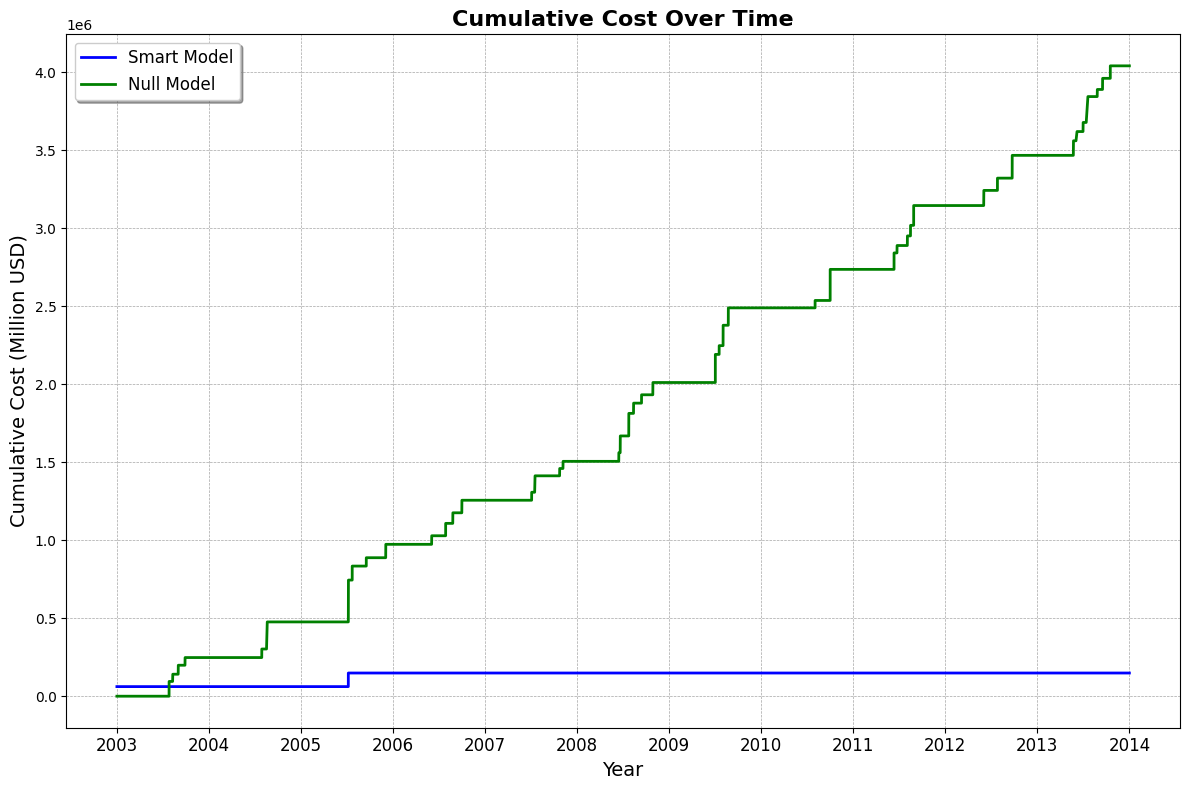

In [13]:
# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(
    dates, flood_df['Cumulative Cost Smart'], 
    label="Smart Model", color='blue', linewidth=2, linestyle='-'
)
plt.plot(
    dates, flood_df['Cumulative Cost Null'], 
    label="Null Model", color='green', linewidth=2, linestyle='-'
)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Cumulative Cost (Million USD)', fontsize=14)
plt.title('Cumulative Cost Over Time', fontsize=16, fontweight='bold')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.xticks(fontsize=12)
plt.grid(visible=True, which='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)
plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d87d8e13-4aeb-4aa6-a43e-003a872f77ba' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>